In [1]:
from __future__ import print_function

from IPython import display

import math
import matplotlib
import sklearn
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from numpy import radians, cos, sin, arcsin, arccos, sqrt, pi, arctan2, degrees, arctan
import itertools
from datetime import datetime
from scipy import signal,ndimage, misc, stats
 
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()
tqdm.pandas(tqdm_notebook)

import osrm
from joblib import dump, load

from natsort import natsorted

from xgboost import XGBRegressor

pd.options.display.max_rows = 10

In [2]:
chunk = 0
taxi = []
for df in pd.read_csv('/mnt/hgfs/FYP/train_porto.csv', chunksize = 100000):
    taxi.append(df)
    chunk += 1
    if chunk > 2:
        break

In [3]:
taxi = pd.concat(taxi)

In [4]:
taxi = taxi.iloc[:,2:]

In [5]:
taxi

,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."
...,...,...,...,...,...,...,...
299995,NaN,18.0,20000597,1378565660,A,False,"[[-8.61984,41.148009],[-8.620452,41.147397],[-..."
299996,NaN,40.0,20000256,1378548158,A,False,"[[-8.674056,41.15385],[-8.674029,41.153697],[-..."
299997,30035.0,NaN,20000074,1378563003,A,False,"[[-8.658,41.153967],[-8.65827,41.153841],[-8.6..."
299998,NaN,NaN,20000361,1378566039,A,False,"[[-8.609679,41.140665],[-8.609463,41.140008],[..."


In [6]:
taxi2 = taxi.sample(50000)

In [7]:
taxi[taxi.POLYLINE.map(len) > 3000].POLYLINE.map(len)

45         3164
93         3077
104        3279
505       11221
515        3140
          ...  
299911     3157
299946     6730
299988     3552
299989     4010
299991     3080
Name: POLYLINE, Length: 5904, dtype: int64

In [8]:
result = taxi.iloc[2]

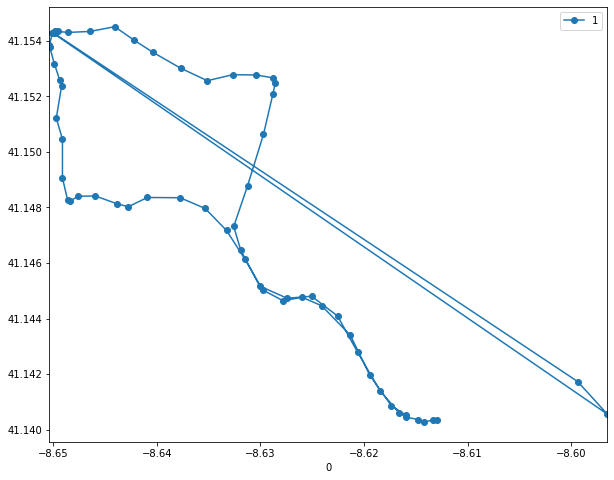

In [9]:
import ast
polyline = ast.literal_eval(result['POLYLINE'])
pd.DataFrame(polyline).plot(0,1, style = 'o-', figsize = (10,8))

In [10]:
def haversine(lat1, lon1, lat2, lon2):
    #ensure using numpy and not math, or pandas series cannot be passed
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * arcsin(sqrt(a))
    r = 6378.137 ##radius of earth km
    return c * r

def shift5(arr, num, fill_value=np.nan):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

def cosrule_arr(arr):
    r = 6378.137
    next_arr = shift5(arr,1)
    c = haversine(arr[:,0], arr[:,1],
                    next_arr[:,0], next_arr[:,1])
    next_arr2 = shift5(next_arr, 1)
    a = haversine(next_arr[:,0], next_arr[:,1],
                    next_arr2[:,0], next_arr2[:,1])
    b = haversine(arr[:,0], arr[:,1],
                    next_arr2[:,0], next_arr2[:,1])
    a = a/r
    b= b/r
    c = c/r
    cosb = (c**2 + a**2 - b**2)/(2*a*c)
    return np.arccos(cosb) * 57.2958

def cosrule(df):
    r = 6378.137
    next_df = df.shift(1)
    c = haversine(df.iloc[:,0], df.iloc[:,1],
                    next_df.iloc[:,0], next_df.iloc[:,1])
    next_df2 = next_df.shift(1)
    a = haversine(next_df.iloc[:,0], next_df.iloc[:,1],
                    next_df2.iloc[:,0], next_df2.iloc[:,1])
    b = haversine(df.iloc[:,0], df.iloc[:,1],
                    next_df2.iloc[:,0], next_df2.iloc[:,1])
    a = a/r
    b= b/r
    c = c/r
    cosb = (c**2 + a**2 - b**2)/(2*a*c)
    return np.arccos(cosb) * 57.2958

In [11]:
a = pd.DataFrame(polyline)

In [12]:
a.iloc[16,1] = 41.15392221329425

In [13]:
a['angle'] = cosrule(a.astype(float))

In [14]:
b = a[(a['angle'] < 30).shift(-1).fillna(False)]

In [15]:
b

,0,1,angle
16,-8.628804,41.153922,155.577012
32,-8.649936,41.154300,140.184495
35,-8.596530,41.140566,171.703820
37,-8.650395,41.153814,109.521285


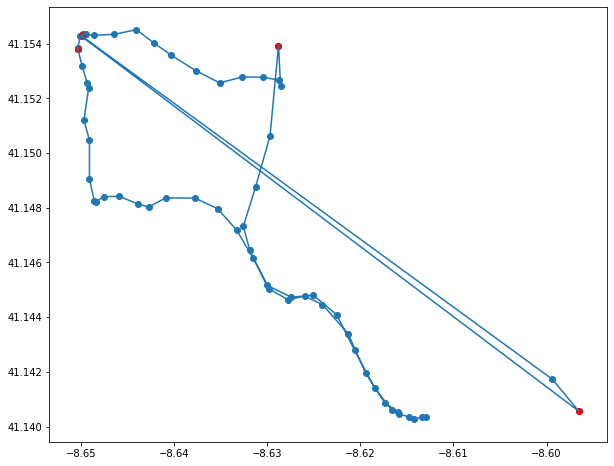

In [16]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(a[0],a[1])
ax.scatter(a[0],a[1])
ax.scatter(b[0], b[1], color='red')

/home/ericlow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


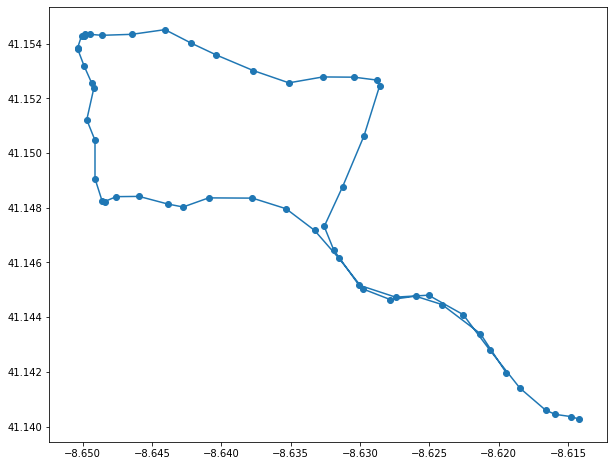

In [981]:
b = a[(a['angle'] > 30).shift(-1).fillna(False)]
b['angle'] = cosrule(b.astype(float))
b = b[(b['angle'] > 30).shift(-1).fillna(False)]

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(b[0],b[1])
ax.scatter(b[0],b[1])

In [624]:
ang = cosrule_arr(np.array(polyline))

In [625]:
a = np.append(np.array(polyline), ang.reshape(-1,1), axis = 1)

In [632]:
print((a[:,2] < 30).any())
a = a[~shift5(a[:,2] < 30, -1)]
a[:,2] = cosrule_arr(a)
a = a[~shift5(a[:,2] < 30, -1)]


True


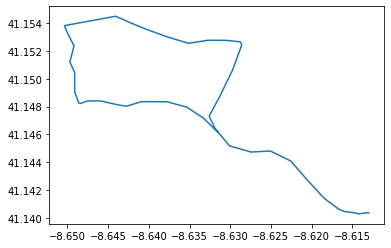

In [633]:
plt.plot(a[:,0], a[:,1])

In [12]:
out = []
for index, row in tqdm(taxi2.iterrows()):
    try: 
        time_stamp = row['TIMESTAMP']
        polyline = ast.literal_eval(row['POLYLINE'])
        ts = []
        for i in range(0,len(polyline)):
#             ts.append(pd.to_datetime(time_stamp, unit = 's'))
            ts.append(datetime.fromtimestamp(time_stamp))
            time_stamp += 15
        
#         polyline = ast.literal_eval(row['POLYLINE'])
        a = np.array(polyline)
        ang = cosrule_arr(a)
        a = np.append(a, ang.reshape(-1,1), axis = 1)
        a = np.append(a, np.array(ts).reshape(-1,1), axis =1)
        while (a[:,2] < 30).any():
            a = a[~shift5(a[:,2] < 30, -1)] 
            a[:,2] = cosrule_arr(a[:,0:2].astype(float))
    except IndexError:
        pass
    out.append(pd.DataFrame(a))

#     a = pd.DataFrame(polyline)
#     a['angle'] = cosrule(a)
#     b = a[a['angle'] < 30]
#     if not b.empty:
#         p

0it [00:00, ?it/s]/home/ericlow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/ericlow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in arccos
50000it [01:11, 697.33it/s]


In [14]:
out[1]

,0,1,2,3
0,-8.61763,41.1462,NaN,2013-07-03 04:37:01
1,-8.61761,41.1459,NaN,2013-07-03 04:37:16
2,-8.61738,41.1449,171.352,2013-07-03 04:37:31
3,-8.61772,41.1444,131.753,2013-07-03 04:37:46
4,-8.61828,41.1437,177.892,2013-07-03 04:38:01
...,...,...,...,...
61,-8.65982,41.16,178.643,2013-07-03 04:52:16
62,-8.65977,41.1601,155.068,2013-07-03 04:52:31
63,-8.65978,41.1601,44.6716,2013-07-03 04:52:46
64,-8.65978,41.1601,NaN,2013-07-03 04:53:01


In [17]:
def mad_based_outlier(points, thresh=3.5):
    shp = points.shape
    points = points.flatten()
    if len(points.shape) ==1:
        points = points[:,None]
    median = np.ma.median(points)
    diff = np.ma.sum((points-median)**2, axis = -1)
    diff = np.ma.sqrt(diff)
    med_abs_deviation = np.ma.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    points = modified_z_score > thresh
    points = np.reshape(points, shp)
    return 1*points


In [18]:
# From this post : http://stackoverflow.com/a/40085052/3293881
def strided_app(a, L, S ):  # Window len = L, Stride len/stepsize = S
    nrows = ((a.size-L)//S)+1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a, shape=(nrows,L), strides=(S*n,n))

# # From this post : http://stackoverflow.com/a/14314054/3293881 by @Jaime
# def moving_average(a, n=3) :
#     ret = np.cumsum(a, dtype=float)
#     ret[n:] = ret[n:] - ret[:-n]
#     return ret[n - 1:] / n

def mad_numpy(a, W):
    a2D = strided_app(a,W,1)
    return mad_based_outlier(a2D)
    return np.absolute(a2D - moving_average(a,W)[:,None]).mean(1)

In [ ]:
mad_numpy(np.array(polyline)[:,0], 15)

In [109]:
np.array(polyline).shape

(65, 2)

In [966]:
a = ndimage.median_filter(foo[:,0],size =5)
b = ndimage.median_filter(foo[:,1],size =5)

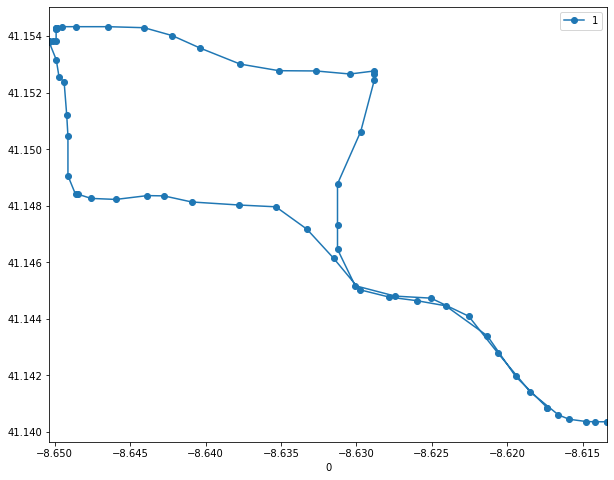

In [967]:
pd.DataFrame([a,b]).T.plot(0,1, style ='o-', figsize = (10,8))

In [858]:
def running_mean(x ,N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N])/float(N)


In [963]:
foo = np.array(polyline)

In [964]:
foo[16,1] = 41.15392221329425

In [965]:
foo = foo.astype(float)

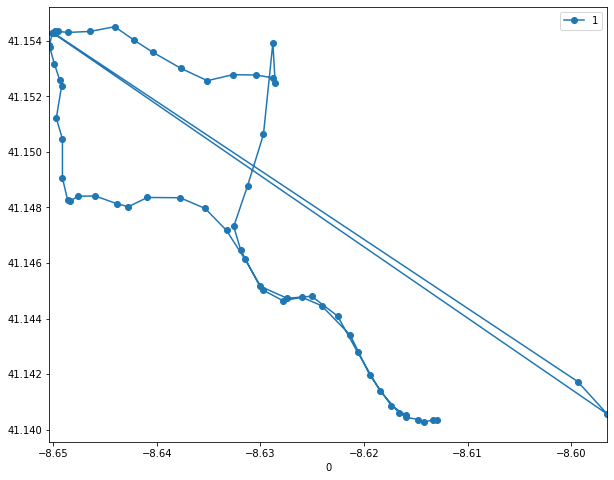

In [961]:
pd.DataFrame(foo).plot(0,1,  style ='o-', figsize = (10,8))

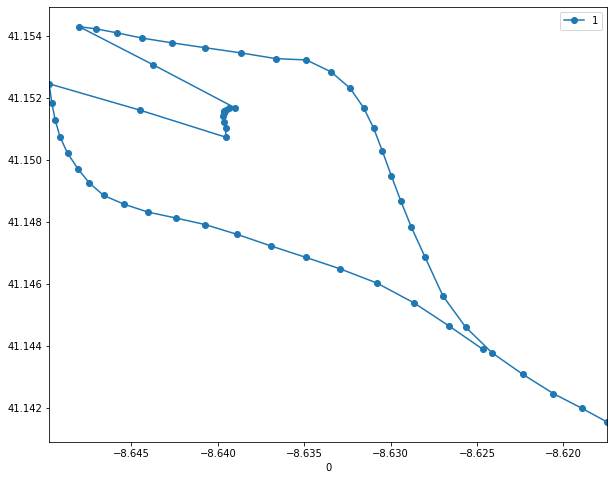

In [962]:
a = running_mean(foo[:,0], 10)
b = running_mean(foo[:,1], 10)
pd.DataFrame([a,b]).T.plot(0,1, style ='o-', figsize = (10,8))

In [935]:
polyline = pd.eval(result['POLYLINE'])
long, lat = zip(*polyline)
time_stamp = result['TIMESTAMP']
ts = []
for i in range(0,len(polyline)):
    ts.append(pd.to_datetime(time_stamp, unit = 's'))
#     ts.append(datetime.fromtimestamp(time_stamp))
    time_stamp += 15
foo = []
foo.append(ts)
foo.append(long)
foo.append(lat)   
    

In [936]:
foo = pd.DataFrame(foo).T

In [ ]:
foo.values

In [ ]:
for index, row in taxi.iterrows():
    if row['MISSING_DATA']== True:
        pass
    polyline = pd.eval(row['POLYLINE'])

In [241]:
def spherical_dist(pos1, pos2, r=6378137):
    '''
    stackexchange 19413259
    '''
    pos1 = pos1 * pi/180
    pos2 = pos2 * pi/180
    cos_lat1 = cos(pos1[..., 1])
    cos_lat2 = cos(pos2[..., 1])
    cos_lat_d = cos(pos1[..., 1] - pos2[..., 1])
    cos_lon_d = cos(pos1[..., 0] - pos2[..., 0])
    return r * arccos(cos_lat_d - cos_lat1 * cos_lat2 * (1 - cos_lon_d))


def time_dif(time1, time2):
    return abs(time1 - time2) / np.timedelta64(1, 's')

def speed_array_calc(df, N, window_size):
    '''
    calculates the distance, time and speed of every point wrt to every other point
    '''
    locations = df[["longitude", "latitude"]].iloc[N:N+window_size].values.astype(float)
    dist_array = spherical_dist(locations[:, None], locations)
    try:
        time_val = np.array(pd.to_datetime(df["time_utc"], format="%Y-%m-%d %H:%M:%S.%f", errors='raise').iloc[N:N+window_size])
    except(KeyError):
        time_val = np.array(pd.to_datetime(df["time"], format="%Y-%m-%d %H:%M:%S.%f", errors='raise').iloc[N:N+window_size])
#     time_val = np.array(pd.to_datetime(kinematics["time"], format="%Y-%m-%d %H:%M:%S.%f", errors='raise'))
    time_array = time_dif(time_val[:, None], time_val)
    speed_array = np.divide(dist_array, time_array)#, out = np.zeros_like(dist_array), where=time_array!=0)
    print(speed_array)
    '''
    calculate z score of the array
    ideally a point very far off from the rest would have high zscore for its speed
    '''
    speed_array = np.ma.array(speed_array, mask = np.isnan(speed_array))
    
    speed_array = abs(stats.zscore(speed_array, axis=None))

    np.fill_diagonal(speed_array, 0)
    np.set_printoptions(precision=4, suppress = True)
    print(np.array(speed_array))
    speed_array[speed_array < 1.96] = 0
    speed_array[speed_array > 0 ] = 1
    print(np.array(speed_array))
    # # speed_array = scipy.special.expit(speed_array)
    # np.fill_diagonal(speed_array, 0)
    return speed_array

def speed_array_calc_mad(df, N, window_size):
    np.set_printoptions(precision=3)
    locations = df[["longitude", "latitude"]].iloc[N:N+window_size].values.astype(float)
    dist_array = spherical_dist(locations[:, None], locations)
#     print(dist_array)
    time_val = np.array(pd.to_datetime(df["time"], format="%Y-%m-%d %H:%M:%S.%f", errors='raise').iloc[N:N+window_size])
#     time_val = np.array(pd.to_datetime(kinematics["time"], format="%Y-%m-%d %H:%M:%S.%f", errors='raise'))
    time_array = time_dif(time_val[:, None], time_val)
    speed_array = np.divide(dist_array, time_array)#, out = np.zeros_like(dist_array), where=time_array!=0)
    print(speed_array)

    speed_array = np.ma.array(speed_array, mask = np.isnan(speed_array))

    speed_array = mad_based_outlier(speed_array)
    np.fill_diagonal(speed_array, 0)
    print(speed_array)
    return speed_array

def outlier_find(df, window_size):
    '''
    Based on Koyak algorithm for outlier detection
    Generates the list 'out' of indexs which are deemed outliers wrt to other points
    the input A array is still experimental
    '''
    out = np.zeros(0)
    for N in range(0, df.shape[0], window_size):
        A = speed_array_calc(df, N, window_size)
        n = A.shape[0]
        b = np.sum(A, axis = 1)
        o = np.zeros(shape = n)
        while ((np.amax(b) > 0)):
            r = np.argmax(b)
            o[r] = 1
            b[r] = 0
            for j in range (0, n):
                if (o[j] == 0):
                    b[j] = b[j] - A[r][j]
        out = np.append(out, o)
    return out

In [235]:
polyline = ast.literal_eval(result['POLYLINE'])
# long, lat = zip(*polyline)
time_stamp = result['TIMESTAMP']
ts = []
for i in range(0,len(polyline)):
    ts.append(pd.to_datetime(time_stamp, unit = 's'))
    time_stamp += 15
# foo = []
# foo.append(ts)
foo = np.append(np.array(ts).reshape(-1,1), polyline, axis = 1)  

In [236]:
foo = pd.DataFrame(foo)

In [237]:
foo.iloc[20,2] = 41.16392221329425
# foo.iloc[24,2] = 41.1692221329425

In [238]:
foo.columns = ['time', 'longitude', 'latitude']

In [239]:
foo = foo[18:25]

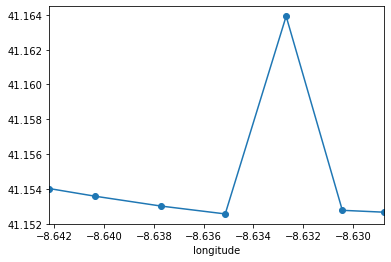

In [240]:
foo.plot(x = 'longitude', y=  'latitude', style = 'o-', legend = None)

In [242]:
np.set_printoptions(precision=4)
outlier_find(foo, 8)

[[    nan  9.3885 43.2033 11.8881 12.5269 13.0464 12.643 ]
 [ 9.3885     nan 83.7209 13.1736 13.5752 13.9614 13.2964]
 [43.2033 83.7209     nan 85.4026 42.8427 29.3085 22.6797]
 [11.8881 13.1736 85.4026     nan 14.7659 15.0891 13.6609]
 [12.5269 13.5752 42.8427 14.7659     nan 15.421  13.1173]
 [13.0464 13.9614 29.3085 15.0891 15.421      nan 10.8166]
 [12.643  13.2964 22.6797 13.6609 13.1173 10.8166     nan]]
[[0.     0.6716 0.885  0.5565 0.5271 0.5032 0.5218]
 [0.6716 0.     2.7502 0.4973 0.4789 0.4611 0.4917]
 [0.885  2.7502 0.     2.8276 0.8684 0.2454 0.0597]
 [0.5565 0.4973 2.8276 0.     0.424  0.4092 0.4749]
 [0.5271 0.4789 0.8684 0.424  0.     0.3939 0.4999]
 [0.5032 0.4611 0.2454 0.4092 0.3939 0.     0.6058]
 [0.5218 0.4917 0.0597 0.4749 0.4999 0.6058 0.    ]]
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


/home/ericlow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


array([0., 0., 1., 0., 0., 0., 0.])

In [ ]:
foo['outliers'] = outlier_find(foo, 11).astype(bool)

In [ ]:
outliers = outlier_find(foo, 11).astype(bool)

In [49]:
foo[~outliers]

,time,longitude,latitude
0,2013-07-01 00:02:31,-8.61296,41.1404
1,2013-07-01 00:02:46,-8.61338,41.1403
2,2013-07-01 00:03:01,-8.61421,41.1403
3,2013-07-01 00:03:16,-8.61477,41.1404
4,2013-07-01 00:03:31,-8.61591,41.1404
...,...,...,...
58,2013-07-01 00:17:01,-8.62781,41.1446
59,2013-07-01 00:17:16,-8.626,41.1448
61,2013-07-01 00:17:46,-8.62133,41.1434
62,2013-07-01 00:18:01,-8.61944,41.142


In [1076]:
foo = foo.iloc[~outliers, :]

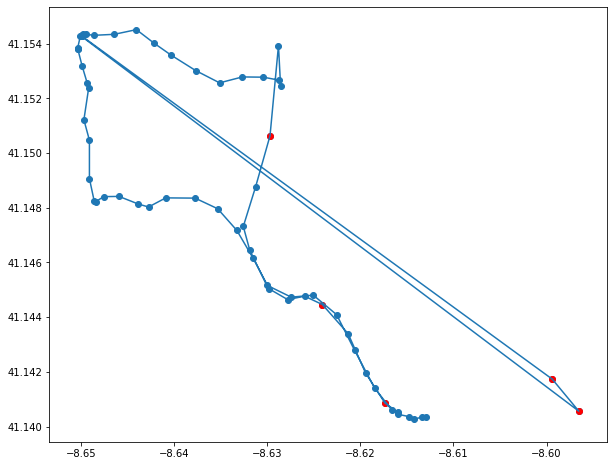

In [24]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(foo['longitude'],foo['latitude'])
ax.scatter(foo['longitude'], foo['latitude'])
ax.scatter(foo[foo['outliers'] == True]['longitude'], foo[foo['outliers'] == True]['latitude'], color='red')

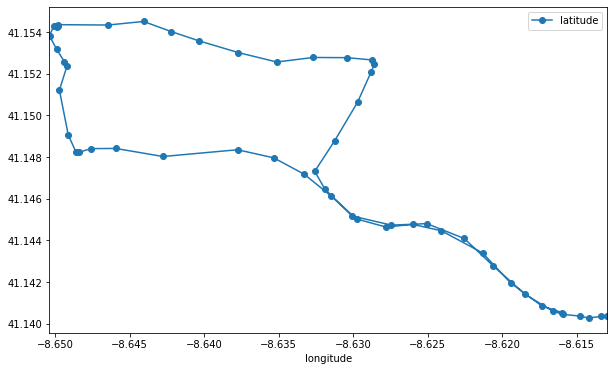

In [1026]:
foo.plot('longitude', 'latitude', style= 'o-', figsize = (10,6))

In [28]:
import sys
for i in range(10000):
    sys.stdout.write("\rDoing thing %i" % i)
    sys.stdout.flush()

Doing thing 9999

In [ ]:
row = result
time_stamp = row['TIMESTAMP']
polyline = ast.literal_eval(row['POLYLINE'])
ts = []
for i in range(0,len(polyline)):
    ts.append(pd.to_datetime(time_stamp, unit = 's'))
    time_stamp += 15

foo = np.append(np.array(ts).reshape(-1,1), polyline, axis = 1)  
foo = pd.DataFrame(foo)
foo.columns = ['time', 'longitude', 'latitude']

wz = int(30 * arctan(0.005*foo.shape[0]))

if (wz > 5):
    outliers = outlier_find(foo, window_size=wz).astype(bool)
else:
    outliers = np.zeros(foo.shape[0]).astype(bool)

foo = foo[~outliers]
#         polyline = ast.literal_eval(row['POLYLINE'])
a = np.array(foo[['time', 'longitude', 'latitude']].values)
ang = cosrule_arr(a[:,1:].astype(float))
a = np.append(a, ang.reshape(-1,1), axis = 1)
# a = np.append(a, np.array(ts).reshape(-1,1), axis =1)
while (a[:,3] < 30).any():
    a = a[~shift5(a[:,3] < 30, -1)] 
    a[:,3] = cosrule_arr(a[:,1:3].astype(float))


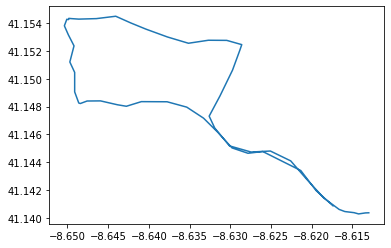

In [57]:
plt.plot(a[:,1], a[:,2])